In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from data_augmentation import random_transform


from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.layers import Dense, Conv2D, MaxPooling2D, Reshape, Flatten, Input, merge
from keras import backend as K

Using TensorFlow backend.


In [2]:
resize_shape = (64, 64)

In [3]:
data = pd.read_csv("data/train.csv")

In [4]:
#For now, we remove new_whale
data = data[data['Id'] != 'new_whale'].reset_index(drop=True)

In [5]:
len(data)

9040

In [6]:
from PIL import Image
image = Image.open('data/train/0a5c0f48.jpg')

In [7]:
image = image.resize(resize_shape)

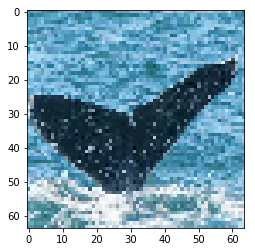

In [8]:
plt.imshow(image)
plt.show()

In [9]:
np.array(image).shape

(64, 64, 3)

In [10]:
gray = np.mean(image, -1)

In [11]:
gray.shape

(64, 64)

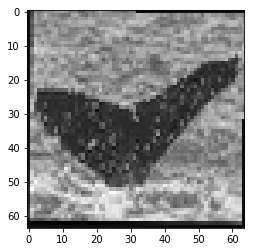

In [21]:
plt.imshow(random_transform(gray),cmap='gray')
plt.show()

In [22]:
from sklearn.model_selection import train_test_split

#TODO: train and test

# files_train, files_test, y_train, y_test = train_test_split(
#     files, y, test_size=0.1, random_state=42)

# All images (if small) can be held in memory.

In [23]:
file_list = data['Image']

In [24]:
def get_image(file, shape=resize_shape):
    image = Image.open('data/train/' + file)
    image = image.resize(shape)
    image = np.array(image)
    if len(image.shape) == 3:
        image = np.mean(image, -1) 
    return image

In [25]:
image_list = [get_image(f) for f in file_list]

In [26]:
data['image_array'] = image_list

In [27]:
from collections import Counter
counts = Counter(data['Id'])
data['Id_count'] = data.apply(lambda x: counts.get(x["Id"]), axis=1)

In [28]:
from random import randint

In [29]:
def get_different_category_example(data):
    index_1 = randint(0,len(data)-1)
    image_1 = data['image_array'][index_1]
    id_1 = data['Id'][index_1]
    id_2 = id_1
    while (id_1 == id_2):
        index_2 = randint(0,len(data)-1)
        id_2 = data['Id'][index_2]
    
    image_2 = data['image_array'][index_2]
    
    image_1 = random_transform(image_1)
    image_2 = random_transform(image_2)
    return image_1, image_2

def get_same_category_example(data):
    filtered = data[data['Id_count'] > 1].reset_index(drop=True)
    index_1 = randint(0,len(filtered)-1)
    image_1 = filtered['image_array'][index_1]
    id_1 = filtered['Id'][index_1]   
    id_2 = id_1
    relevant_indices = list(filtered.index[filtered['Id'] == id_1])
    relevant_indices.remove(index_1)
    index_2 = np.random.choice(relevant_indices)
    image_2 = filtered['image_array'][index_2]
    
    image_1 = random_transform(image_1)
    image_2 = random_transform(image_2)
    return image_1, image_2

In [30]:
def binary_data_generator(batch_size, data, p=0.5):
    while True:
        targets = np.random.randint(2, size=batch_size)
        image_1_batch = np.zeros((batch_size, 64,64))
        image_2_batch = np.zeros((batch_size, 64,64))
        for i in range(batch_size):
            if(targets[i]):
                image_1_batch[i,:,:], image_2_batch[i,:,:] = get_same_category_example(data)
            else:
                image_1_batch[i,:,:], image_2_batch[i,:,:] = get_different_category_example(data)

        pairs = [image_1_batch, image_2_batch]

        yield pairs, targets 

# Create the network

In [31]:
input_shape = resize_shape
left_input = Input(input_shape)
right_input = Input(input_shape)

convnet = Sequential()
convnet.add(Reshape((resize_shape[0],resize_shape[1], 1,), input_shape=(resize_shape[0],resize_shape[1],),name='Reshape'))
convnet.add(Conv2D(filters=8, input_shape=(resize_shape[0],resize_shape[1],1,), kernel_size=3, activation='relu',name='conv_1'))
convnet.add(Conv2D(filters=16, kernel_size=3, activation='relu',name='conv_2'))
convnet.add(MaxPooling2D(pool_size=2,name='pool_1'))
convnet.add(Conv2D(filters=32, kernel_size=3, activation='relu',name='conv_3'))
convnet.add(Conv2D(filters=64, kernel_size=3, activation='relu',name='conv_4'))
convnet.add(MaxPooling2D(pool_size=2,name='pool_2'))
convnet.add(Conv2D(filters=128, kernel_size=3, activation='relu',name='conv_5'))
convnet.add(Conv2D(filters=256, kernel_size=3, activation='relu',name='conv_6'))
convnet.add(MaxPooling2D(pool_size=2,name='pool_3'))
convnet.add(Flatten())
convnet.add(Dense(units=1024, activation='relu',name='dense_1'))

encoded_l = convnet(left_input)
encoded_r = convnet(right_input)
L1_distance = lambda x: K.abs(x[0]-x[1])
both = merge([encoded_l,encoded_r], mode = L1_distance, output_shape=lambda x: x[0])
prediction = Dense(1,activation='sigmoid')(both)
siamese_net = Model(input=[left_input,right_input],output=prediction)

/home/edward/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:22: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/home/edward/miniconda3/lib/python3.5/site-packages/keras/legacy/layers.py:458: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)
/home/edward/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:24: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("de...)`


In [32]:
LEARNING_RATE = 0.0001
siamese_net.compile(loss="binary_crossentropy",optimizer=Adam(LEARNING_RATE), metrics=['accuracy'])

# Run the network

In [33]:
BATCH_SIZE = 8
siamese_data_generator = binary_data_generator(BATCH_SIZE, data)

In [ ]:
history = siamese_net.fit_generator(siamese_data_generator, verbose=1, epochs=100, steps_per_epoch=100)

Epoch 1/100
100/100 [==============================] - 23s 235ms/step - loss: 0.7305 - acc: 0.5588
Epoch 2/100
100/100 [==============================] - 24s 236ms/step - loss: 0.6988 - acc: 0.5613
Epoch 3/100
100/100 [==============================] - 23s 232ms/step - loss: 0.7007 - acc: 0.5550
Epoch 4/100
100/100 [==============================] - 23s 232ms/step - loss: 0.6843 - acc: 0.5812
Epoch 5/100
100/100 [==============================] - 23s 229ms/step - loss: 0.6936 - acc: 0.5837
Epoch 6/100
100/100 [==============================] - 23s 228ms/step - loss: 0.6734 - acc: 0.6038
Epoch 7/100
100/100 [==============================] - 23s 231ms/step - loss: 0.6674 - acc: 0.6138
Epoch 8/100
100/100 [==============================] - 23s 228ms/step - loss: 0.6630 - acc: 0.6150
Epoch 9/100
100/100 [==============================] - 24s 242ms/step - loss: 0.6766 - acc: 0.5962
Epoch 10/100
100/100 [==============================] - 26s 256ms/step - loss: 0.6683 - acc: 0.6038
Epoch 11/

# Save weights

In [ ]:
import time
import os

now = time.strftime('%Y.%m.%d %H:%M:%S')
directory = "weights/" + now + "/"
if not os.path.exists(directory):
    os.makedirs(directory)


siamese_net.save_weights(directory + "siamese_weights")
convnet.save_weights(directory + "convnet_weights")